In [ ]:
!pip install ultralytics

In [124]:
import torch
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
import requests
from ultralytics import YOLO
import os
import random
import math
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'using {device}')

using cuda


In [15]:
yolo_model = YOLO('yolov8n.pt')
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

In [ ]:
!unzip "/content/Aquarium Combined.v2-raw-1024.yolov8.zip" -d /content/aquarium_dataset

# README.dataset
## Aquarium > raw-1024
https://universe.roboflow.com/brad-dwyer/aquarium-combined

Provided by [Roboflow](https://roboflow.com)
License: CC BY 4.0

![CreateML Output](https://i.imgur.com/s4PgS4X.gif)

## Dataset Details

This dataset consists of 638 images collected by Roboflow from two aquariums in the United States: The Henry Doorly Zoo in Omaha (October 16, 2020) and the National Aquarium in Baltimore (November 14, 2020). The images were labeled for object detection by the Roboflow team (with some help from SageMaker Ground Truth). Images and annotations are released under a Creative Commons By-Attribution license. You are free to use them for any purposes personal, commercial, or academic provided you give acknowledgement of their source.

## Class Breakdown

The following classes are labeled: fish, jellyfish, penguins, sharks, puffins, stingrays, and starfish. Most images contain multiple bounding boxes.

![Class Balance](https://i.imgur.com/lFzeXsT.png)

## Usage

The dataset is provided in many popular formats for easily training machine learning models. We have [trained a model with CreateML](https://blog.roboflow.com/createml/) (see gif above).

This dataset could be used for coral reef [conservation](https://blog.roboflow.com/how-this-fulbright-scholar-is-using-computer-vision-to/), [environmental health monitoring](https://blog.roboflow.com/using-computer-vision-to-count-fish-populations/), swimmer [safety](https://roboflow.com/industries/safety-and-security), pet analytics, automated feeding, and much more. We're excited to see what you build!


In [39]:
!cat /content/aquarium_dataset/data.yaml

train: ../train/images
val: ../valid/images
test: ../test/images

nc: 7
names: ['fish', 'jellyfish', 'penguin', 'puffin', 'shark', 'starfish', 'stingray']

roboflow:
  workspace: brad-dwyer
  project: aquarium-combined
  version: 2
  license: CC BY 4.0
  url: https://universe.roboflow.com/brad-dwyer/aquarium-combined/dataset/2

In [40]:
names = ['fish', 'jellyfish', 'penguin', 'puffin', 'shark', 'starfish', 'stingray']

In [34]:
!cat /content/aquarium_dataset/test/labels/IMG_2289_jpeg_jpg.rf.fe2a7a149e7b11f2313f5a7b30386e85.txt
print('\n'+'-'*50)
!cat /content/aquarium_dataset/test/labels/IMG_3173_jpeg_jpg.rf.6f05acaa0b22d410a5df3ea3286e227d.txt
print('\n'+'-'*50)
!cat /content/aquarium_dataset/test/labels/IMG_3129_jpeg_jpg.rf.90c472dcdf9b6713ec767cc97560ceca.txt

3 0.4453125 0.5888671875 0.5104166666666666 0.236328125
--------------------------------------------------
2 0.5107421875 0.4934895833333333 0.28515625 0.14713541666666666
2 0.8212890625 0.3046875 0.0400390625 0.09505208333333333
2 0.1611328125 0.37109375 0.0380859375 0.08854166666666667
2 0.9765625 0.2903645833333333 0.044921875 0.08723958333333333
2 0.578125 0.3203125 0.064453125 0.0703125
2 0.884765625 0.3059895833333333 0.04296875 0.06901041666666667
2 0.0458984375 0.34375 0.0625 0.055989583333333336
2 0.2158203125 0.328125 0.0341796875 0.053385416666666664
2 0.1728515625 0.3333333333333333 0.03515625 0.048177083333333336
2 0.2568359375 0.2981770833333333 0.0224609375 0.04296875
2 0.873046875 0.4791666666666667 0.2529296875 0.16666666666666666
--------------------------------------------------
5 0.55859375 0.6201171875 0.4713541666666667 0.138671875

The data is in some yolo v8 format ive never heard of:
(see https://roboflow.com/formats/yolov8-pytorch-txt)

*"Each image has one txt file with a single line for each bounding box.

The format of each row is
**class_id center_x center_y width height**"*

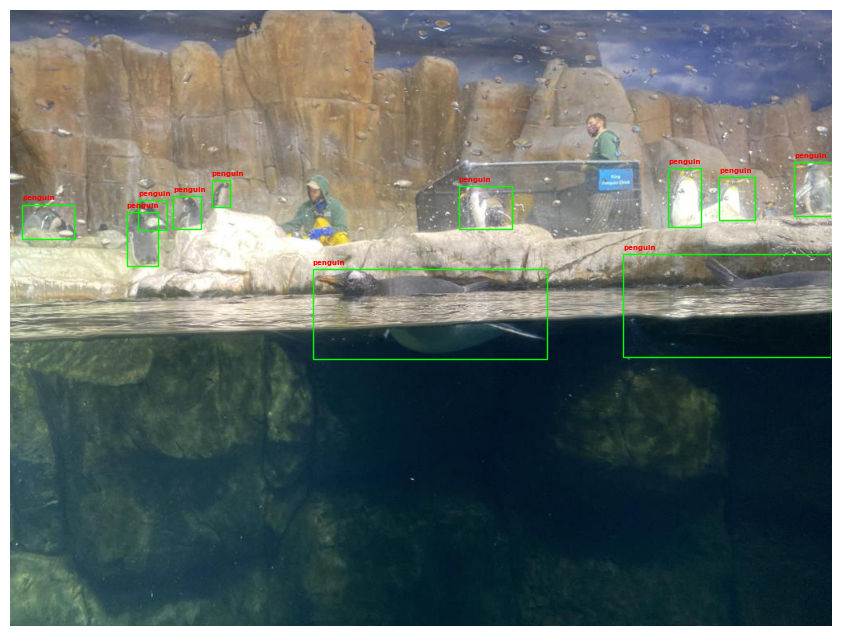

In [104]:
image_path = "/content/aquarium_dataset/test/images/IMG_3173_jpeg_jpg.rf.6f05acaa0b22d410a5df3ea3286e227d.jpg"
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
H, W, _ = image.shape

label_path = "/content/aquarium_dataset/test/labels/IMG_3173_jpeg_jpg.rf.6f05acaa0b22d410a5df3ea3286e227d.txt"
boxes = []


with open(label_path, 'r') as f:
    for line in f.readlines():
        vals = line.strip().split()
        class_id = int(vals[0])
        x_center, y_center, w, h = map(float, vals[1:])

        x1 = int((x_center - w/2) * W)
        y1 = int((y_center - h/2) * H)
        x2 = int((x_center + w/2) * W)
        y2 = int((y_center + h/2) * H)

        boxes.append((x1, y1, x2, y2, class_id))

plt.figure(figsize=(12, 8))
plt.imshow(image_rgb)
ax = plt.gca()

for (x1, y1, x2, y2, class_id) in boxes:
    rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, edgecolor='lime', facecolor='none', linewidth=1)
    ax.add_patch(rect)
    ax.text(x1, y1-5, names[class_id], color='red', fontsize=5, fontweight='bold')

plt.axis('off')
plt.show()

/content/aquarium_dataset/test/images/IMG_2477_jpeg_jpg.rf.7b2692f142d53c16ad477065f1f8ae6d.jpg
/content/aquarium_dataset/test/labels/IMG_2477_jpeg_jpg.rf.7b2692f142d53c16ad477065f1f8ae6d.txt


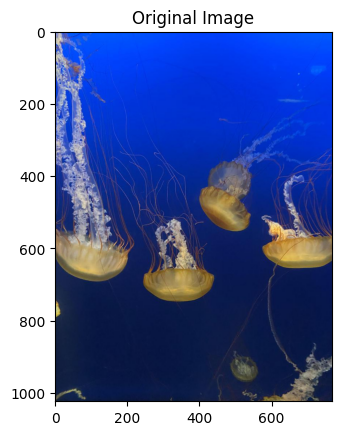

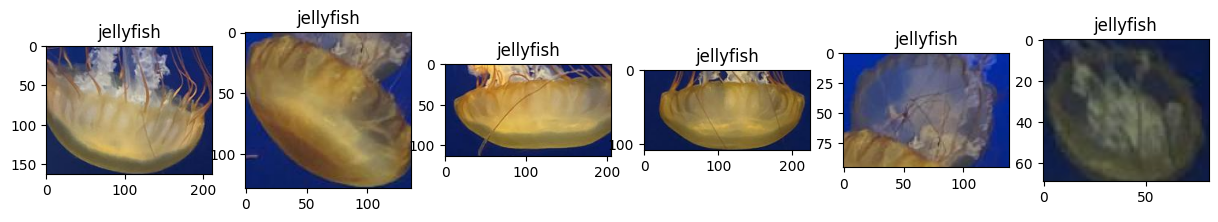

In [102]:
test_img_dir = "/content/aquarium_dataset/test/images"
test_lbl_dir = "/content/aquarium_dataset/test/labels"
sample_image = random.choice([
  f for f in os.listdir(test_img_dir)
  if f.lower().endswith(('.jpg'))
])

image_path = os.path.join(test_img_dir, sample_image)
label_path = os.path.join(test_lbl_dir, sample_image.replace(".jpg", ".txt"))
print(image_path)
print(label_path)

boxes = []
img = Image.open(image_path)
W, H = img.size

with open(label_path, 'r') as f:
    for line in f.readlines():
        vals = line.strip().split()
        class_id = int(vals[0])
        x_center, y_center, w, h = map(float, vals[1:])
        x1 = int((x_center - w/2) * W)
        y1 = int((y_center - h/2) * H)
        x2 = int((x_center + w/2) * W)
        y2 = int((y_center + h/2) * H)
        boxes.append((x1, y1, x2, y2, class_id))

crops = []
crop_classes = []

for (x1, y1, x2, y2, c) in boxes:
    crop = img.crop((x1, y1, x2, y2))
    crops.append(crop)
    crop_classes.append(c)


plt.imshow(img)
plt.title('Original Image')
plt.show()

if len(crops) > 0:
  f, a = plt.subplots(1, len(crops), figsize=(15, 15))
  a = a.ravel()

  for i in range(len(crops)):
      a[i].imshow(crops[i])
      a[i].set_title(names[crop_classes[i]])

  plt.show()
else:
  print("No IDs found")


Our classes: ['fish', 'jellyfish', 'penguin', 'puffin', 'shark', 'starfish', 'stingray']


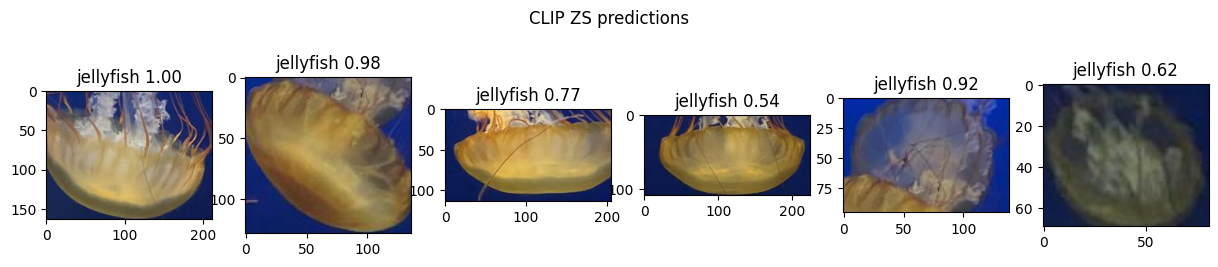

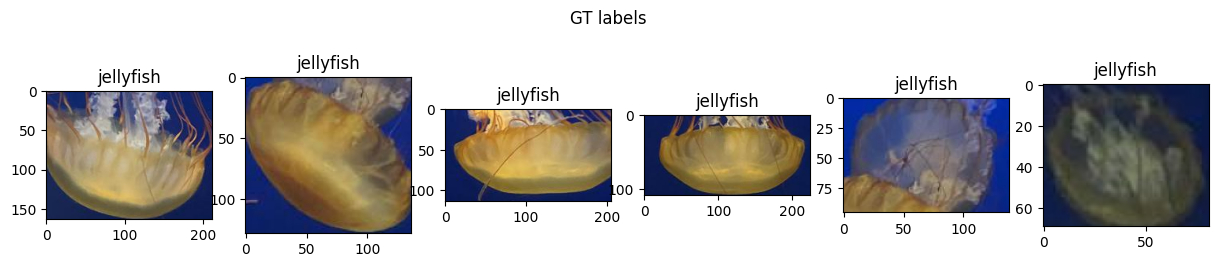

In [103]:
print(f'Our classes: {names}')

def classify_with_clip(image):
    inputs = processor(
        text=names,
        images=image,
        return_tensors="pt",
        padding=True
    ).to("cuda")

    outputs = clip_model(**inputs)
    logits_per_image = outputs.logits_per_image
    probs = logits_per_image.softmax(dim=1).cpu().detach().numpy()
    predicted_idx = probs.argmax()
    predicted_label = names[predicted_idx]
    confidence = probs[0][predicted_idx]

    return predicted_label, confidence

clip_preds = []
for crop in crops:
  pred_label, conf = classify_with_clip(crop)
  clip_preds.append((pred_label, conf))

f, a = plt.subplots(1, len(crops), figsize=(15, 3))
a = a.ravel()
for i in range(len(crops)):
    a[i].imshow(crops[i])
    label, conf = clip_preds[i]
    a[i].set_title(f"{label} {conf:.2f}")
f.suptitle("CLIP ZS predictions", fontsize=12)
plt.show()

f, a = plt.subplots(1, len(crops), figsize=(15, 3))
a = a.ravel()
for i in range(len(crops)):
    a[i].imshow(crops[i])
    a[i].set_title(names[crop_classes[i]])
f.suptitle("GT labels", fontsize=12)
plt.show()

#TODO: Lets use an object detector to find these crops and pass it to CLIP; CLIP seems to perform well in classifying the crops extracted from the GT labels.
This means that CLIPs performance will depend on the quality of the detection network; weaker detectors will inevitably lead to poorer CLIP performance due to missed or incorrectly localized objects.

To mitigate this issue when evaluating CLIP on this specific dataset, we can instead/first/also loop through the test data and run predictions on the ground-truth (GT) crops. This approach provides an unbiased metric of CLIPs accuracy on this dataset, independent of the detection networks performance.

## Predicting on ground truth crops!

In [126]:
# I ran into issues with this where the boxes width and height was messy (0 or neg height/width) this is a bit messy but i got some results
# messy boxes will be ignored

all_gt = []
all_clip = []
all_conf = []
all_ref_img = []

for fname in tqdm(os.listdir(test_img_dir)):
    if not fname.lower().endswith(('.jpg')):
        continue

    image_path = os.path.join(test_img_dir, fname)
    label_path = os.path.join(test_lbl_dir, os.path.splitext(fname)[0] + ".txt")

    img = Image.open(image_path)
    W, H = img.size

    boxes = []
    crop_classes = []

    # read labels
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            for line in f.readlines():
                vals = line.strip().split()
                class_id = int(vals[0])
                x_center, y_center, w, h = map(float, vals[1:])
                x1 = int((x_center - w/2) * W)
                y1 = int((y_center - h/2) * H)
                x2 = int((x_center + w/2) * W)
                y2 = int((y_center + h/2) * H)

                if x2 <= x1 or y2 <= y1:
                    continue

                boxes.append((x1, y1, x2, y2, class_id))
                crop_classes.append(class_id)

    crops = [img.crop((x1, y1, x2, y2)) for (x1, y1, x2, y2, _) in boxes]

    for i, crop in enumerate(crops):
        inputs = processor(
            text=names,
            images=crop,
            return_tensors="pt",
            padding=True
        ).to(device)

        outputs = clip_model(**inputs)
        logits_per_image = outputs.logits_per_image
        probs = logits_per_image.softmax(dim=1).cpu().detach().numpy()
        pred_idx = probs.argmax()
        pred_label = names[pred_idx]
        confidence = probs[0][pred_idx]

        all_gt.append(names[crop_classes[i]])
        all_clip.append(pred_label)
        all_conf.append(confidence)
        all_ref_img.append(image_path)


100%|██████████| 63/63 [01:14<00:00,  1.19s/it]


In [127]:
correct = sum([gt==pred for gt, pred in zip(all_gt, all_clip)])
total = len(all_gt)
accuracy = correct / total

print(f"Zero shot accuracy on the crops: {accuracy:.3f} ({correct}/{total})")

Zero shot accuracy on the crops: 0.536 (312/582)


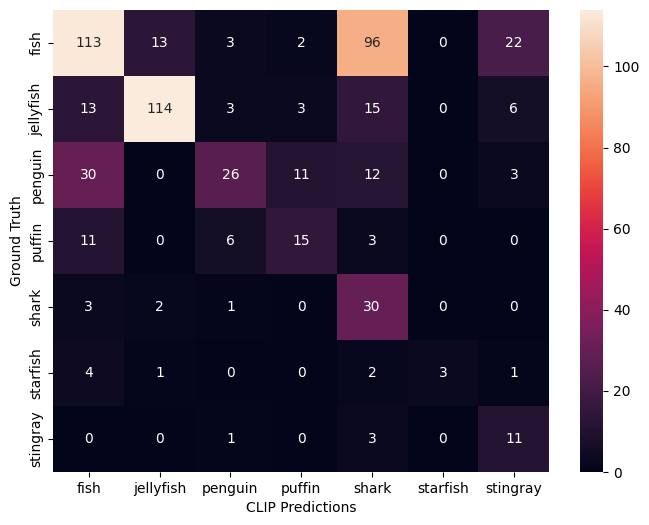

In [128]:
cm = confusion_matrix(all_gt, all_clip, labels=names)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=names, yticklabels=names)
plt.xlabel("CLIP Predictions")
plt.ylabel("Ground Truth")
plt.show()

In [130]:
pred_df = pd.DataFrame({
    "Ground Truth": all_gt,
    "CLIP Prediction": all_clip,
    "Confidence": all_conf,
    "Reference Image": all_ref_img
})

display(pred_df)
display(pred_df[pred_df["Ground Truth"] != pred_df["CLIP Prediction"]])

,Ground Truth,CLIP Prediction,Confidence,Reference Image
0,starfish,starfish,0.671479,/content/aquarium_dataset/test/images/IMG_2532...
1,starfish,shark,0.415442,/content/aquarium_dataset/test/images/IMG_2532...
2,penguin,penguin,0.928349,/content/aquarium_dataset/test/images/IMG_2319...
3,penguin,puffin,0.651021,/content/aquarium_dataset/test/images/IMG_2319...
4,penguin,penguin,0.510013,/content/aquarium_dataset/test/images/IMG_2319...
...,...,...,...,...
577,fish,shark,0.291800,/content/aquarium_dataset/test/images/IMG_2499...
578,fish,shark,0.289572,/content/aquarium_dataset/test/images/IMG_2499...
579,fish,shark,0.461002,/content/aquarium_dataset/test/images/IMG_2499...
580,fish,shark,0.367100,/content/aquarium_dataset/test/images/IMG_2499...


,Ground Truth,CLIP Prediction,Confidence,Reference Image
1,starfish,shark,0.415442,/content/aquarium_dataset/test/images/IMG_2532...
3,penguin,puffin,0.651021,/content/aquarium_dataset/test/images/IMG_2319...
5,penguin,puffin,0.331707,/content/aquarium_dataset/test/images/IMG_2319...
7,penguin,fish,0.303152,/content/aquarium_dataset/test/images/IMG_2319...
9,penguin,puffin,0.560712,/content/aquarium_dataset/test/images/IMG_2319...
...,...,...,...,...
576,fish,shark,0.358681,/content/aquarium_dataset/test/images/IMG_2499...
577,fish,shark,0.291800,/content/aquarium_dataset/test/images/IMG_2499...
578,fish,shark,0.289572,/content/aquarium_dataset/test/images/IMG_2499...
579,fish,shark,0.461002,/content/aquarium_dataset/test/images/IMG_2499...
